In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)

import tensorflow.keras.backend as K

In [23]:
IMG_SIZE =32
N_CHANNELS = 1
BATCH_SIZE = 100
EMBEDDINGS_DIM = 2  
BETA = 500
LEARNING_RATE = 0.0005
EPOCHS = 5
VALIDATION_SPLIT = 0.2
#capitalized variables are constants (not indended to change)

In [21]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 4s 1us/step


In [22]:
# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0 #scale values between 0 and 1

    #pad each image to 32x32 for easier manipulation of tensorshape as it passes though the network
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0) 
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Encoder

Encoder needs to map each input to a mean vector and variance vector. Variational autoencoders assume that there is no correlation between dimensions in the latent space.

Variance values always positve, choose to map the log of the variance (can take any real number). So we can use a neural network as the encoder to map input image to the mean and log variance vectors.

to sample a point from the distribution: z = z_mean +z_sigma*epsilon (epsilon randomly sampled from a normal dist)
z_sigma = exp(z_log_var*0.5)

In [7]:
#create a sampling layer to sample from the distribution defined by z_mean and z_log_var

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        #sameple epsilon from normal dist
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [28]:
encoder_input = layers.Input(shape= (IMG_SIZE,IMG_SIZE, N_CHANNELS))
x = layers.Conv2D(32, kernel_size = 3, strides = 2, padding = "same", activation = "relu")(encoder_input)
x= layers.Conv2D(64, kernel_size = 3, strides = 2, padding = "same", activation = "relu")(x)
x = layers.Conv2D(128, 3, strides = 2, padding = "same", activation = "relu")(x)
shape_before_flattening = K.int_shape(x)[1:] #needed for the decoder

x= layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDINGS_DIM, name= "z_mean")(x)
z_log_var = layers.Dense(EMBEDDINGS_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name = "encoder")

In [29]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_8[0][0]']               
                                                                                            

# Decoder

In [30]:
decoder_input = layers.Input(shape = (EMBEDDINGS_DIM, ), name = "encoder_input") # the , in the shape automatically fills in the rest
x =  layers.Dense(np.prod(shape_before_flattening))(decoder_input) #np.prod is the product of elements in an array
x = layers.Reshape(shape_before_flattening)(x) #reshapes vector back into a tensor to be fed into the conv2d transpose layer
x= layers.Conv2DTranspose(
    128, 3, strides =2, activation = 'relu', padding = "same"
)(x)
x= layers.Conv2DTranspose(
    64, 3, strides =2, activation = 'relu', padding = "same"
)(x)
x= layers.Conv2DTranspose(
    32, 3, strides =2, activation = 'relu', padding = "same"
)(x)
decoder_output = layers.Conv2D(1, 3, strides=1, activation = "sigmoid", padding = "same")(x) #each pixel value ouput a value between 0 and 1 with sigmoid

decoder = models.Model(decoder_input, decoder_output)

# Training

In [31]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA*losses.binary_crossentropy(data, reconstruction, axis= (1,2,3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(1+ z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis =1,))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [32]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [33]:
# create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [34]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5


600/600 [==============================] - 204s 331ms/step - total_loss: 161.0622 - reconstruction_loss: 156.5898 - kl_loss: 4.4723 - val_loss: 142.3453 - val_reconstruction_loss: 137.5737 - val_kl_loss: 4.7716
Epoch 2/5
600/600 [==============================] - 225s 375ms/step - total_loss: 136.1273 - reconstruction_loss: 131.1229 - kl_loss: 5.0042 - val_loss: 138.2334 - val_reconstruction_loss: 133.1825 - val_kl_loss: 5.0508
Epoch 3/5
600/600 [==============================] - 220s 367ms/step - total_loss: 134.2964 - reconstruction_loss: 129.2305 - kl_loss: 5.0659 - val_loss: 137.0546 - val_reconstruction_loss: 131.8821 - val_kl_loss: 5.1725
Epoch 4/5
600/600 [==============================] - 221s 368ms/step - total_loss: 133.3081 - reconstruction_loss: 128.1956 - kl_loss: 5.1123 - val_loss: 136.0768 - val_reconstruction_loss: 130.8611 - val_kl_loss: 5.2157
Epoch 5/5
600/600 [==============================] - 215s 359ms/step - total_loss: 132.7151 - reconstruction_loss: 127.5567 - 

In [35]:
# save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


total_loss
reconstruction_loss


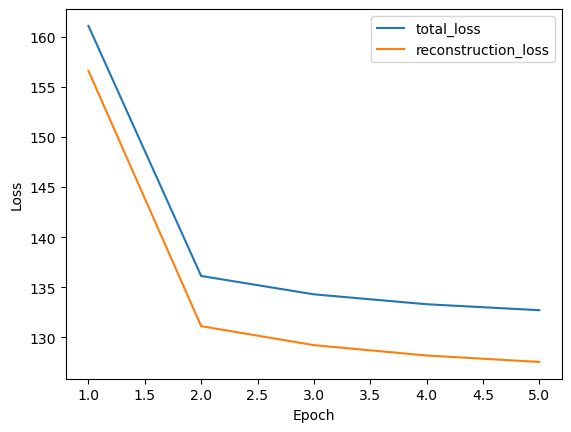

In [54]:
history = vae.history
metrics = history.history.keys()
for metric in ['total_loss','reconstruction_loss']:
    print(metric)
    plt.plot(np.linspace(1, EPOCHS, EPOCHS),history.history[metric], label = metric)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [55]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [58]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)

  1/157 [..............................] - ETA: 14s

157/157 [==============================] - 8s 51ms/step


Text(0.5, 0.48, 'Reconstructions')

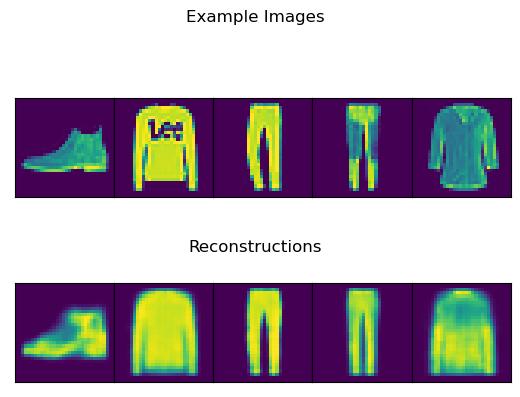

In [68]:
num_to_show = 5
fig, axs = plt.subplots(2,num_to_show)

plt.subplots_adjust(wspace=0, hspace=0)
for i in range(num_to_show):
    axs[0,i].imshow(example_images[i])
    axs[1,i].imshow(reconstructions[i])

    # Remove x and y ticks and labels for each subplot
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[0, i].set_xticklabels([])
    axs[0, i].set_yticklabels([])
    axs[1, i].set_xticklabels([])
    axs[1, i].set_yticklabels([])

fig.text(0.5, 0.96, "Example Images", ha='center', va='center', fontsize=12)
fig.text(0.5, 0.48, "Reconstructions", ha='center', va='center', fontsize=12)

# Embed using the encoder

In [69]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)
# Some examples of the embeddings
print(z[:10])

157/157 [==============================] - 2s 10ms/step
[[ 0.28651026  1.4153899 ]
 [ 0.94764924 -0.47883412]
 [-0.6895654  -2.8109643 ]
 [-1.7037623  -1.9157685 ]
 [ 0.19405696 -0.12895836]
 [-0.5090066  -1.9731    ]
 [-0.98274946 -0.00710189]
 [-0.10874759 -0.06288918]
 [-2.6899548   1.5280802 ]
 [-1.0425856   1.3064432 ]]


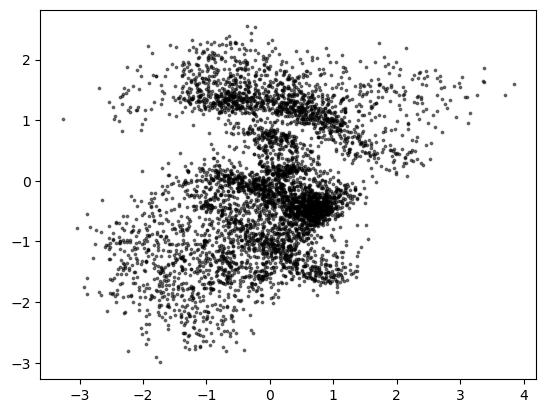

In [70]:
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

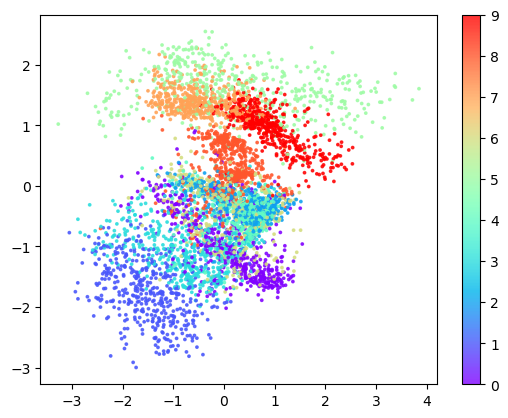

In [72]:
plt.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar()
plt.show()

In [74]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 292ms/step


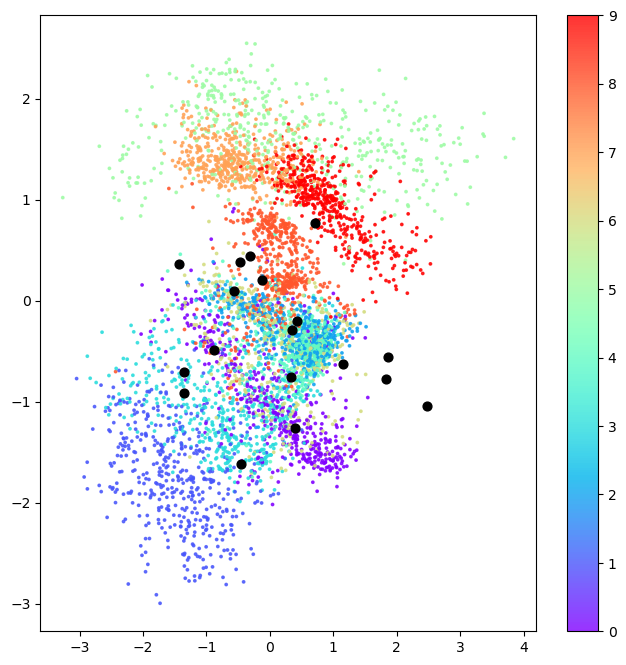

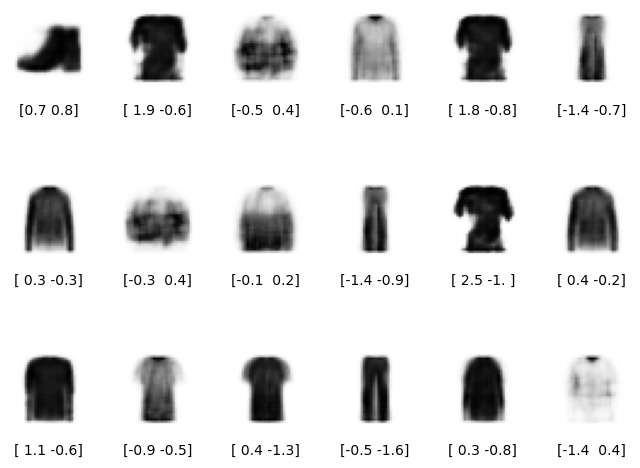

In [78]:

figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
#plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)
plt.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar()
# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="black", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")